In [343]:
import os, io, warnings, glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare

# Cancer Data Merging

## Load in Files

In [344]:
directory = os.getcwd()

clinical_files = glob.glob(os.path.join(directory, "**/*clinical_short*"), recursive=True)
somatic_files = glob.glob(os.path.join(directory, "**/*somatic_short*"), recursive=True)
clinical_files.sort()
somatic_files.sort()

file_paths = clinical_files + somatic_files
file_paths.sort()
file_paths

gene_expected = glob.glob(os.path.join(directory, "**/*gene_expected*"), recursive=True)

### File Parsing

In [345]:
cancer_pairs = {'LAML': [], 'ACC': [], 'SKCM': [], 'BRCA': []}

for file in file_paths:
    if 'somatic' in os.path.basename(file):
        cancer_type = os.path.basename(file).split('.')[0]
        cancer_pairs[cancer_type].append({'somatic': file})
    elif 'clinical' in os.path.basename(file):
        # Extract the cancer type from the file name (before the dot).
        cancer_type = os.path.basename(file).split('.')[0]
        cancer_pairs[cancer_type].append({'clinical': file})

for cancer_type, pairs in cancer_pairs.items():
    somatic_data = None
    clinical_data = None
    
    for pair in pairs:
        if 'somatic' in pair:
            somatic_data = pd.read_csv(pair['somatic'], compression='gzip', comment='#', delimiter='\t')
            somatic_data[['affected protein', 'protein length']] = somatic_data['prot.pos'].str.extract(r'(\d+)/(\d+)')
            # Extract reference and alternative allele 
            somatic_data[['reference', 'alternative allele']] = somatic_data['aa'].str.extract(r'(\w+)/(\w+)')
            # Extract the patient identifier 
            somatic_data['patient'] = somatic_data['sample_id'].str.extract(r'(\w+)-(\w+)-(\w+)').apply('-'.join, axis=1)
        elif 'clinical' in pair:
            with open(pair['clinical'], 'r') as f:
                clinical_data = f.read()
            clinical_data = pd.read_csv(io.StringIO(clinical_data), sep='\t')

    # Merge somatic and clinical data on 'patient'
    clinical_somatic = pd.merge(somatic_data, clinical_data, on='patient', how='inner')
    print(f"Merged data for {cancer_type}: {clinical_somatic.shape}")


Merged data for LAML: (6716, 27)
Merged data for ACC: (5913, 27)
Merged data for SKCM: (336541, 27)
Merged data for BRCA: (96963, 27)


# Exploratory Analysis

## Clinical Files

In [346]:
def clinical_EDA(file): 
    warnings.filterwarnings("ignore")
    data = pd.read_csv(file, sep='\t')
    data

    missing = data.isna().sum()

    #3
    gender_proportions = data['gender'].value_counts(normalize=True)
    gender_counts = data['gender'].value_counts()
    #Proportion Table
    df_proportion = pd.DataFrame({'Gender': gender_proportions.index, 'Proportion': gender_proportions.values})
    print(df_proportion)
    sns.countplot(data=data, x='gender', palette='Dark2')
    for i, count in enumerate(gender_counts):
        plt.text(i, count, str(count), ha='center', va='baseline', fontsize=12, color = 'black')
    plt.title('Proportion of Male and Female Patients')
    plt.xlabel('Gender')
    plt.ylabel('Proportion')
    plt.show()
    # plt.close()

    #4
    age_clean = data['age_at_diagnosis'].dropna().values
    age_range = np.ptp(age_clean)
    print("Age Range:", round(age_range, 2))
    age_avg = np.average(age_clean)
    print("Average Age:", round(age_avg, 2))
    plt.boxplot(age_clean)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age boxplot')
    mean_age = np.mean(age_clean)
    median_age = np.median(age_clean)
    q1_age = np.percentile(age_clean, 25)
    q3_age = np.percentile(age_clean, 75)
    min_age = np.min(age_clean)
    max_age = np.max(age_clean)
    plt.text(0.73, mean_age, f'Mean: {mean_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.1, median_age, f'Median: {median_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.1, q1_age , f'Q1: {q1_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.1, q3_age, f'Q3: {q3_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.05, min_age, f'Min: {min_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.05, max_age, f'Max: {max_age:.2f}', verticalalignment='center', color = 'black')
    plt.show()
    # plt.close()


    sns.histplot(age_clean, bins=10, kde=True)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age Frequency')
    counts, age_bins = np.histogram(age_clean, bins=10)
    for i, count in enumerate(counts):
        plt.text(age_bins[i] + 3, count, str(count), ha='center', va='bottom', color = 'black')
    plt.show()
    # plt.close()

    #5
    male_age = data[data['gender']=='male']['age_at_diagnosis'].dropna()
    female_age = data[data['gender']=='female']['age_at_diagnosis'].dropna()
    plt.figure(figsize=(8, 6))
    plt.boxplot([male_age, female_age], labels=['Male', 'Female'])
    for i, stats in enumerate([male_age.describe(), female_age.describe()]):
        for j, (stat_name, stat_value) in enumerate([('Min', stats['min']), ('25%', stats['25%']), ('Med', stats['50%']), ('75%', stats['75%']), ('Max', stats['max'])]):
            plt.text(i + 1.1, stat_value, f'{stat_name}: {stat_value:.2f} yrs', verticalalignment='center', color = 'black')
    plt.xlabel('Gender')
    plt.ylabel('Age at Diagnosis')
    plt.title('Age at Diagnosis Distribution by Gender')
    plt.show()
    # plt.close()
    genders = [male_age, female_age]
    for gender in genders:
        sns.histplot(gender, bins=10, kde=True, label='Male' if gender is male_age else 'Female')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age Frequency')
    plt.legend()
    plt.show()
    # plt.close()

    #6
    def clean_stage(stage):
        if 'x' in str(stage).lower():
            return 'x'
        elif 'not reported' in str(stage).lower():
            return str(stage)
        elif '0' in str(stage).lower():
            return 0
        elif 'iv' in str(stage).lower():
            return 'iv'
        elif 'i/ii nos' in str(stage).lower():
            return str(stage)
        else:
            return ''.join([char for char in str(stage).lower() if char =='i'])
            # return str(stage).lower().count('i')
    data['tumor_stage_2'] = data['tumor_stage'].apply(clean_stage)

    # file_name = os.path.basename(file.name)
    # data.to_csv(f'EDA_{file_name}.csv', index = False)


In [347]:
# Cleans data to be visualized 
def clinical_short_CSV(file):
    data = pd.read_csv(file, sep='\t')
    def clean_stage(stage):
        if 'x' in str(stage).lower():
            return 'x'
        elif 'not reported' in str(stage).lower():
            return str(stage)
        elif '0' in str(stage).lower():
            return 0
        elif 'iv' in str(stage).lower():
            return 'iv'
        elif 'i/ii nos' in str(stage).lower():
            return str(stage)
        else:
            return ''.join([char for char in str(stage).lower() if char =='i'])
            # return str(stage).lower().count('i')
    data['tumor_stage_2'] = data['tumor_stage'].apply(clean_stage)

    data.to_csv(file, sep='\t', index=False, header=True)

## ACC

   Gender  Proportion
0  female    0.607595
1    male    0.392405


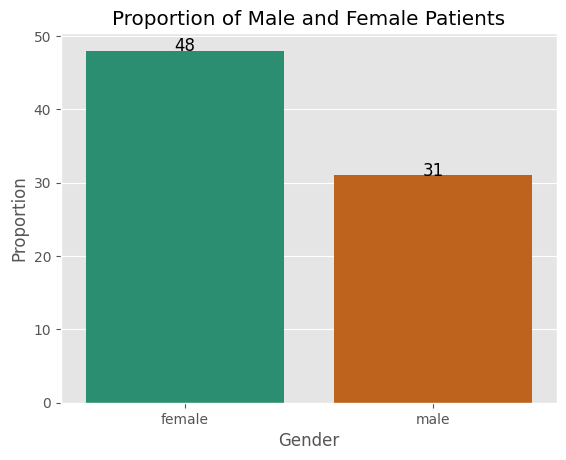

Age Range: 62.7
Average Age: 47.24


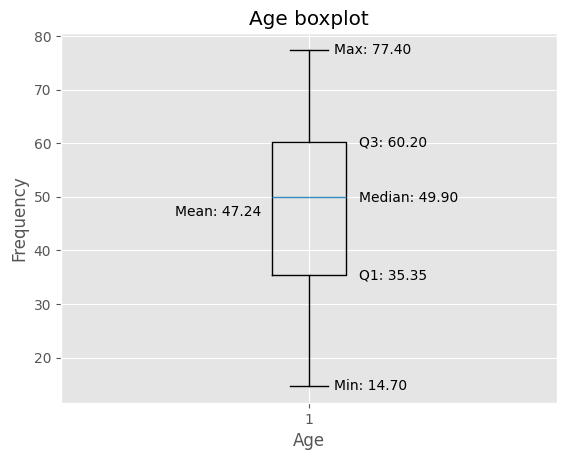

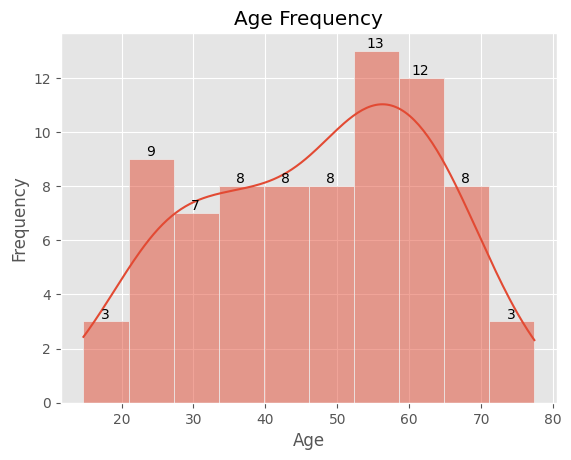

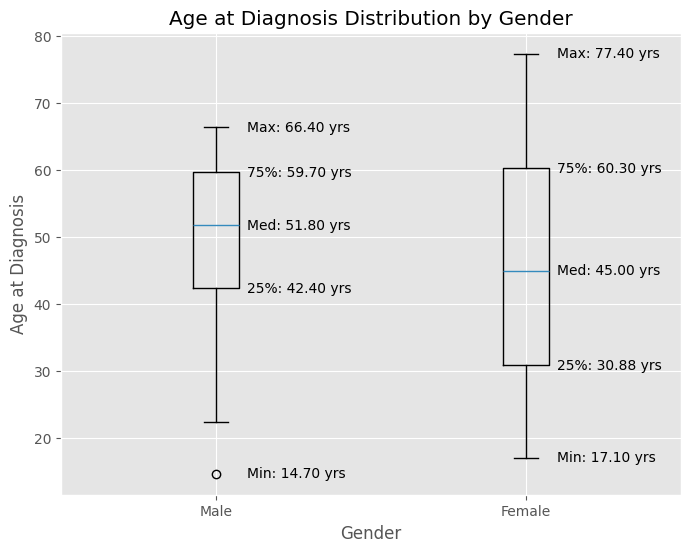

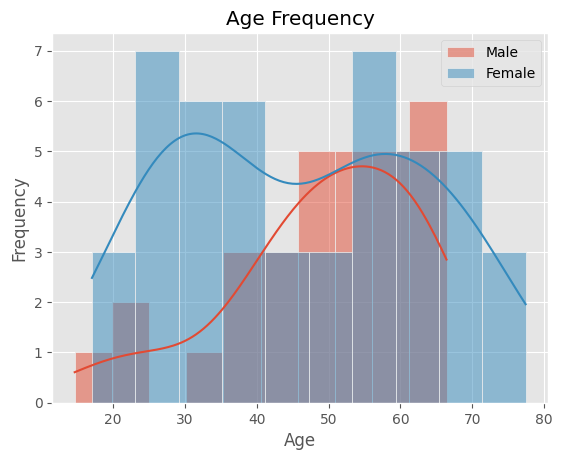

In [349]:
clinical_EDA(clinical_files[0])
clinical_short_CSV(clinical_files[0])

## BRCA

   Gender  Proportion
0  female     0.98917
1    male     0.01083


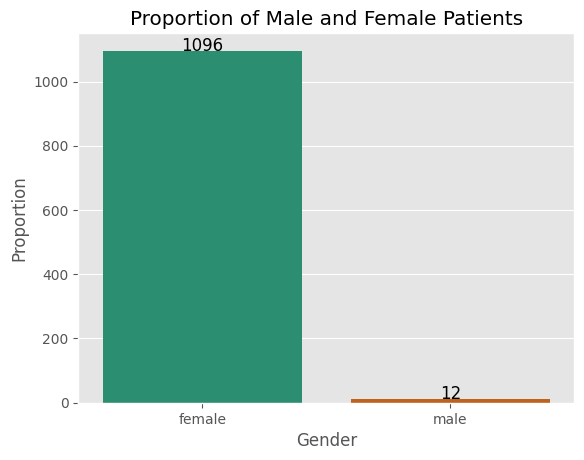

Age Range: 63.4
Average Age: 58.98


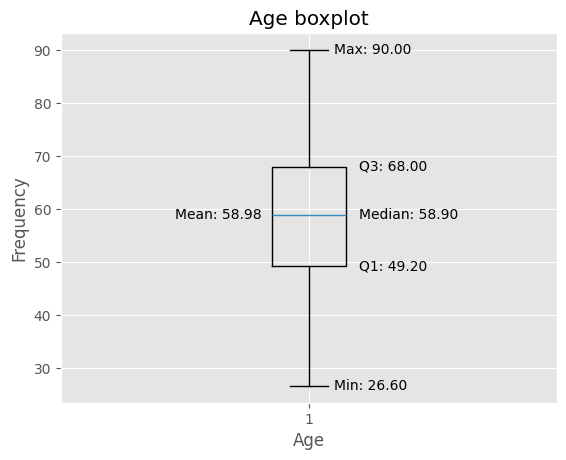

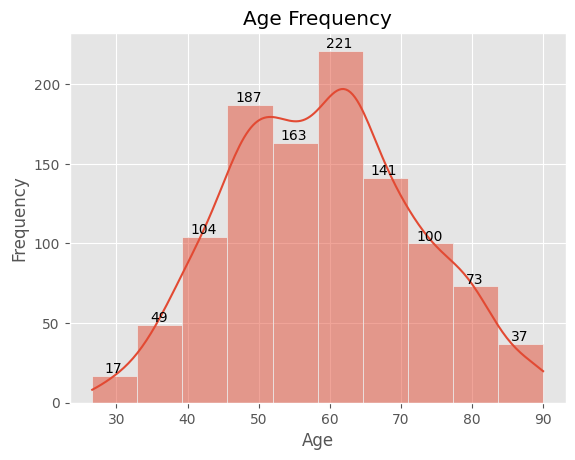

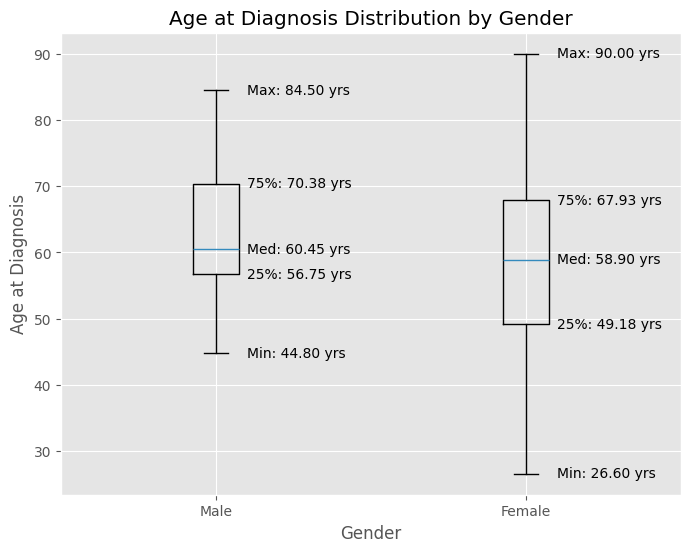

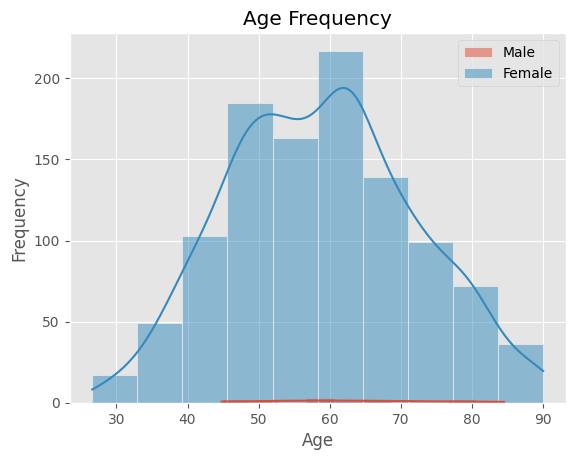

In [350]:
clinical_EDA(clinical_files[1])
clinical_short_CSV(clinical_files[1])

## LAML

   Gender  Proportion
0    male    0.549669
1  female    0.450331


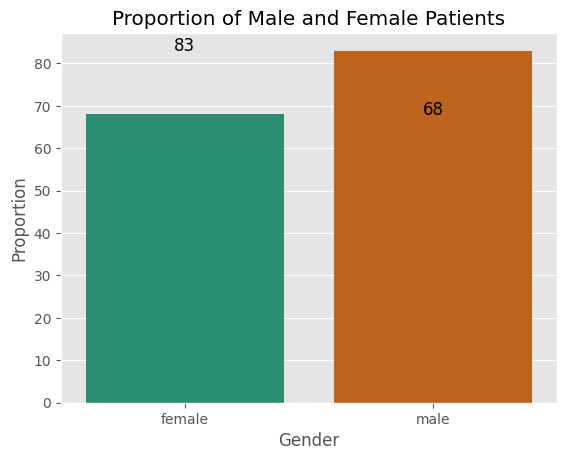

Age Range: 66.9
Average Age: 54.61


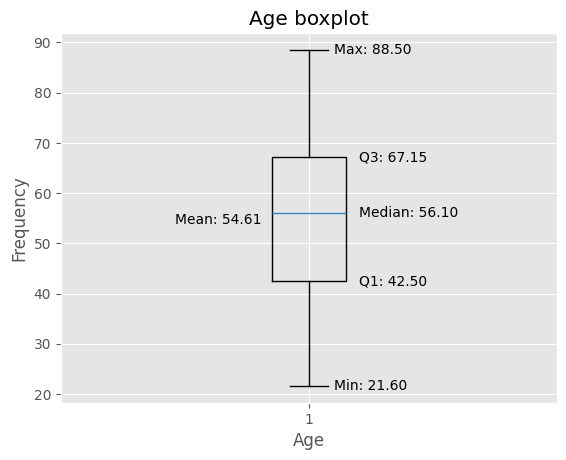

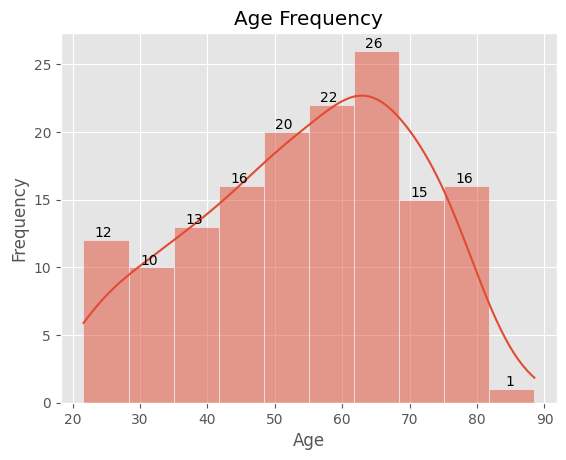

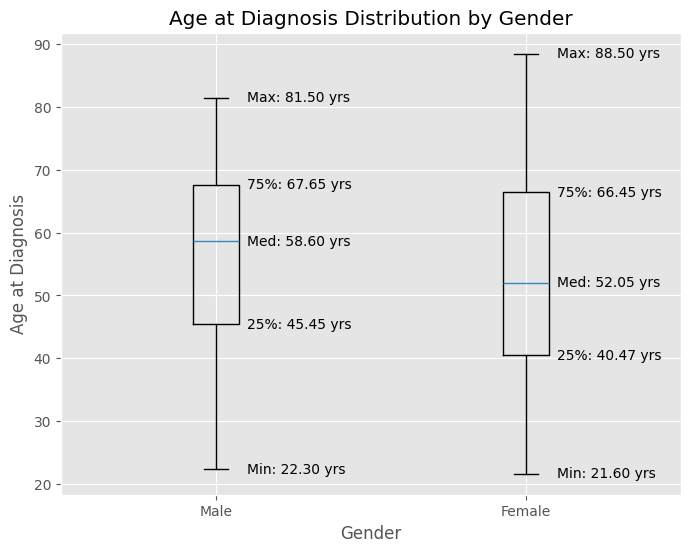

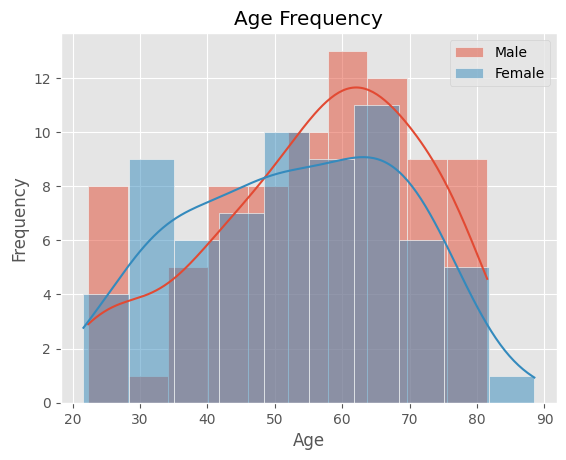

In [351]:
clinical_EDA(clinical_files[2])
clinical_short_CSV(clinical_files[2])

## SKCM

   Gender  Proportion
0    male    0.619958
1  female    0.380042


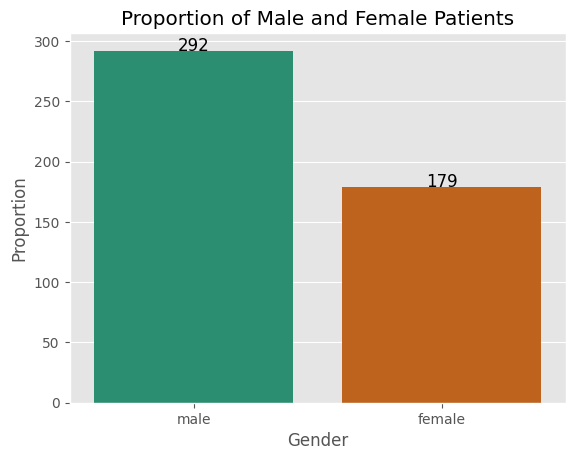

Age Range: 74.4
Average Age: 58.69


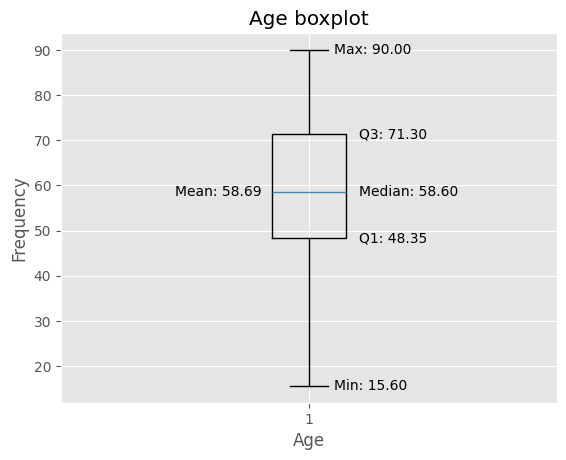

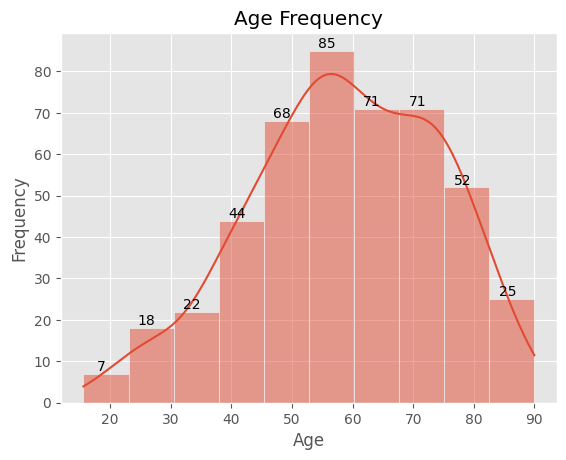

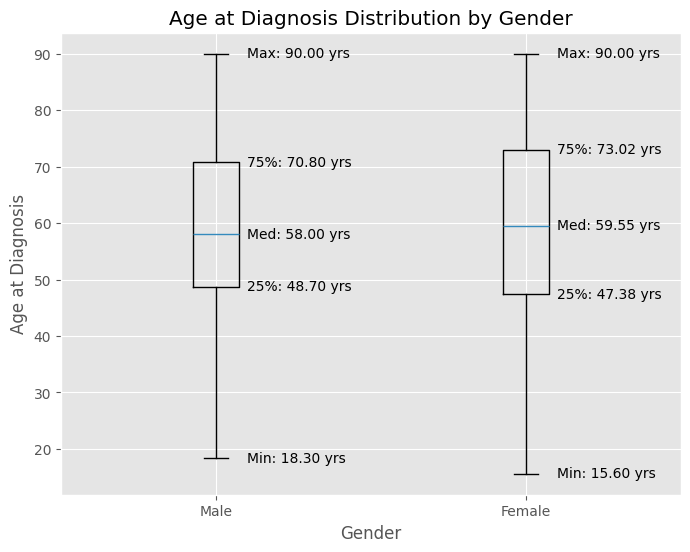

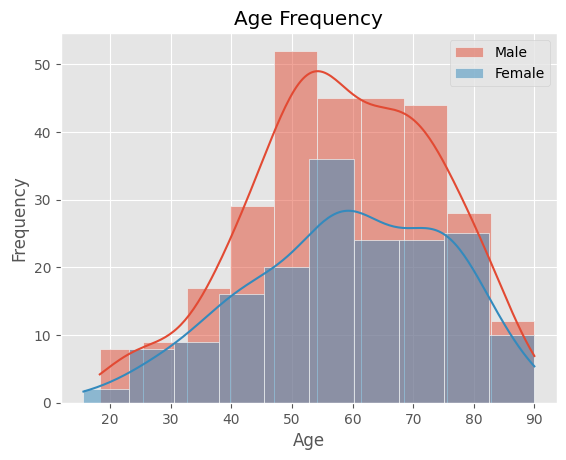

In [352]:
clinical_EDA(clinical_files[3])
clinical_short_CSV(clinical_files[3])

## Somatic Files

In [353]:
EDA_clinical_files = glob.glob(os.path.join(directory, "**/*clinical_short*"), recursive=True)

EDA_clinical_files.sort()

print(EDA_clinical_files,"\n",somatic_files)

['/Users/robertoruizfelix/Downloads/Clinical & Somatic/ACC.clinical_short.txt', '/Users/robertoruizfelix/Downloads/Clinical & Somatic/BRCA.clinical_short.txt', '/Users/robertoruizfelix/Downloads/Clinical & Somatic/LAML.clinical_short.txt', '/Users/robertoruizfelix/Downloads/Clinical & Somatic/SKCM.clinical_short.txt'] 
 ['/Users/robertoruizfelix/Downloads/Clinical & Somatic/ACC.somatic_short.maf.gz', '/Users/robertoruizfelix/Downloads/Clinical & Somatic/BRCA.somatic_short.maf.gz', '/Users/robertoruizfelix/Downloads/Clinical & Somatic/LAML.somatic_short.maf.gz', '/Users/robertoruizfelix/Downloads/Clinical & Somatic/SKCM.somatic_short.maf.gz']


In [357]:
def somatic_EDA(file, file2):
    somatic_short = pd.read_csv(file, compression='gzip', comment='#', delimiter='\t')
    missing = somatic_short.isna().sum()

    #2
    mut_cnt = somatic_short['var_class'].value_counts()
    mut_cnt_df = pd.DataFrame({'Mutation':mut_cnt.index, 'Count':mut_cnt.values})

    mutation_range = np.ptp(mut_cnt)
    print('Mutation Range:', mutation_range)
    mutation_avg = np.average(mut_cnt)
    print('Mutation Average:', round(mutation_avg, 2))

    plt.style.use('ggplot')
    plt.bar(mut_cnt.index, mut_cnt)
    for i, count in enumerate(mut_cnt):
        plt.text(i, count + 50, str(count), ha = 'center', va = 'baseline', fontsize = 11)
    plt.xticks(rotation = 35)
    plt.xlabel('Mutations')
    plt.ylabel('Count')
    plt.title('Mutations Count')
    plt.show()

    plt.boxplot(mut_cnt)
    plt.xlabel('All Mutations')
    plt.ylabel('Counts')
    plt.title('Age boxplot')
    mean_mut = np.mean(mut_cnt)
    median_mut = np.median(mut_cnt)
    q1_age = np.percentile(mut_cnt, 25)
    q3_age = np.percentile(mut_cnt, 75)
    min_age = np.min(mut_cnt)
    max_age = np.max(mut_cnt)
    plt.text(0.7, mean_mut, f'Mean: {mean_mut:.2f}', verticalalignment='center', color = 'black')
    plt.text(0.7, median_mut, f'Median: {median_mut:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.1, q1_age , f'Q1: {q1_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(1.1, q3_age, f'Q3: {q3_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(0.75, min_age, f'Min: {min_age:.2f}', verticalalignment='center', color = 'black')
    plt.text(0.75, max_age, f'Max: {max_age:.2f}', verticalalignment='center', color = 'black')
    plt.show()


    mut_cntt = somatic_short[['sample_id', 'symbol']].groupby('sample_id').count()
    mut_cntt['patient'] = mut_cntt.index 
    mut_cntt['patient'] = mut_cntt['patient'].str.extract('(TCGA-[\w\d]+-[\w\d]+)')
    symbol_description = mut_cntt.symbol.describe()
    mut_count = symbol_description['count']

    clinical_short = pd.read_csv(file2, sep='\t')
    clinical_mut = clinical_short.join(mut_cntt.set_index('patient'), on='patient', how='inner')

    plt.scatter(clinical_mut['age_at_diagnosis'], clinical_mut['symbol'], color='blue')
    plt.title('Mutation Count vs Age at Diagnosis')
    plt.xlabel('Age at Diagnosis')
    plt.ylabel('Mutation Count per Sample')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    clinical_mut.groupby('tumor_stage_2')['symbol'].mean().plot(kind='bar', color='skyblue')
    plt.title('Average Mutation Count per Sample by Tumor Stage 2')
    plt.xlabel('Tumor Stage 2')
    plt.ylabel('Average Mutation Count per Sample')
    plt.grid(axis='y')
    plt.show()

## ACC

Mutation Range: 5552
Mutation Average: 1236.57


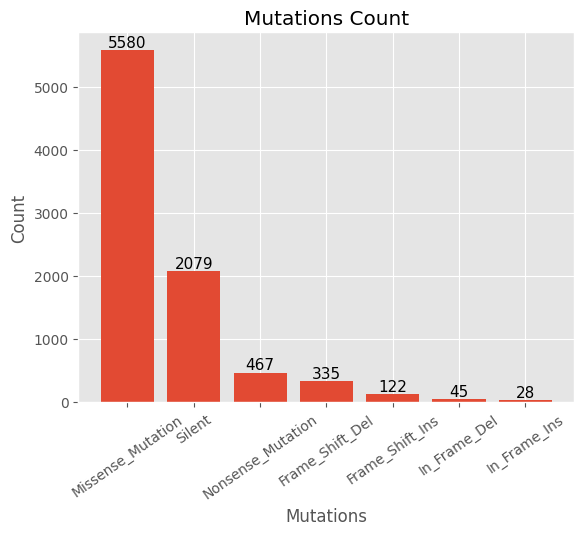

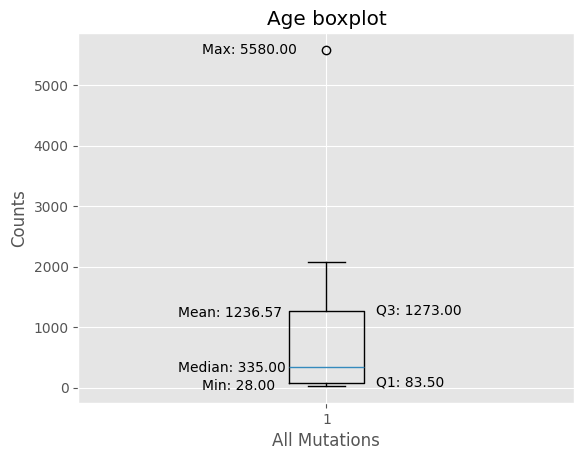

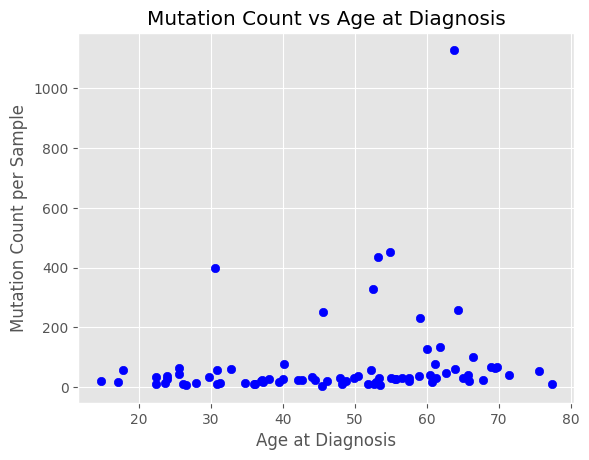

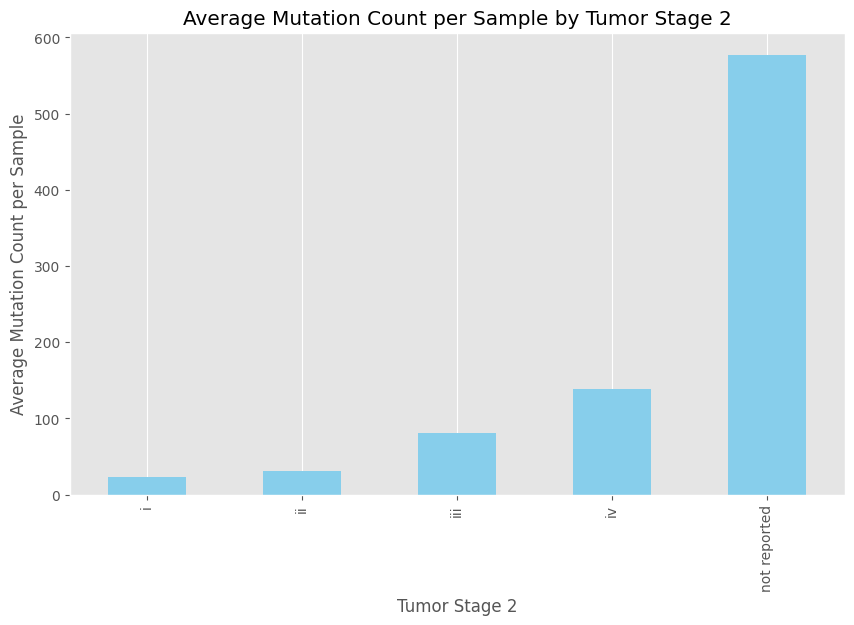

In [358]:
somatic_EDA(somatic_files[0], EDA_clinical_files[0])

## BRCA

Mutation Range: 61896
Mutation Average: 13747.29


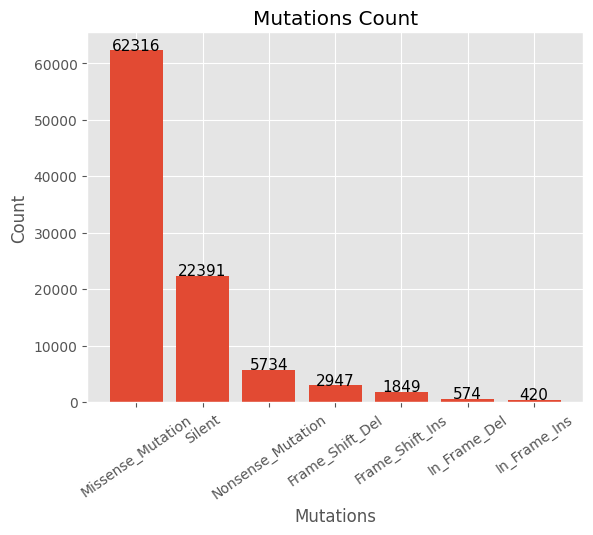

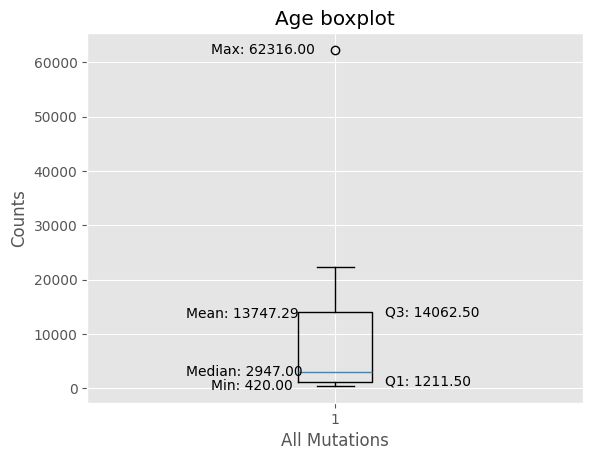

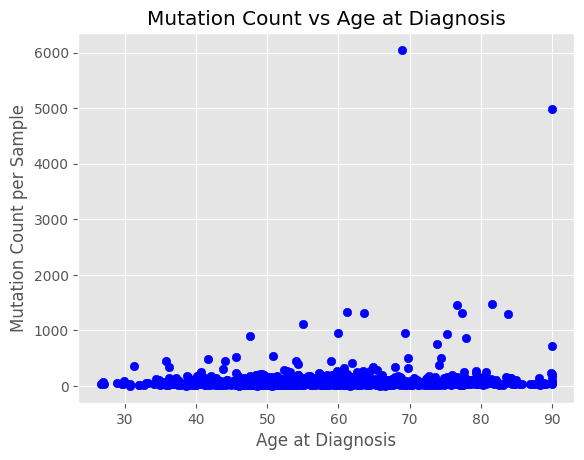

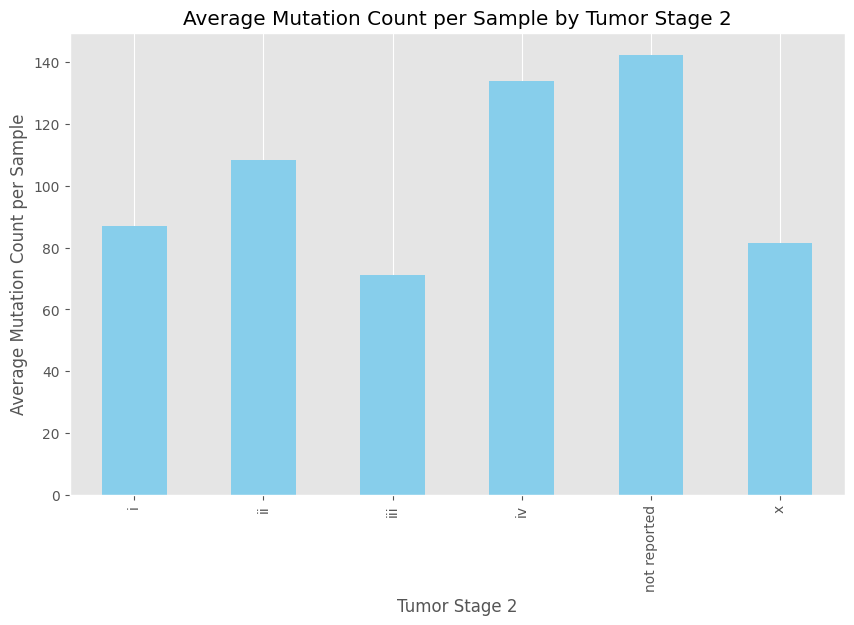

In [359]:
somatic_EDA(somatic_files[1], EDA_clinical_files[1])

## LAML

Mutation Range: 5453
Mutation Average: 1220.29


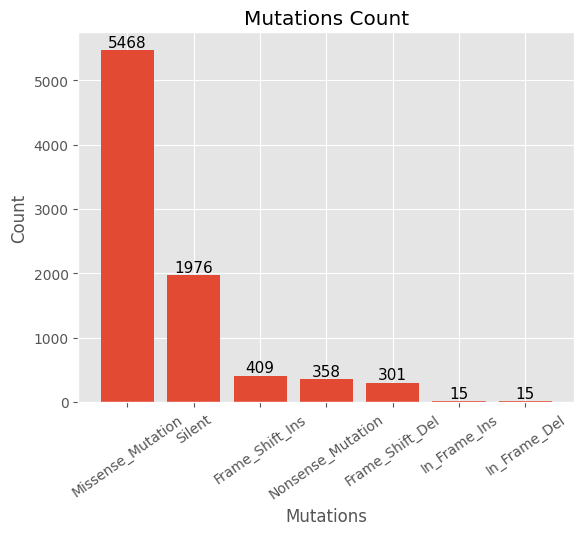

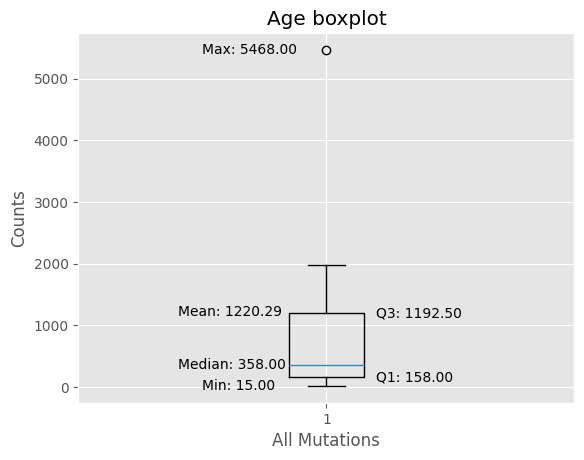

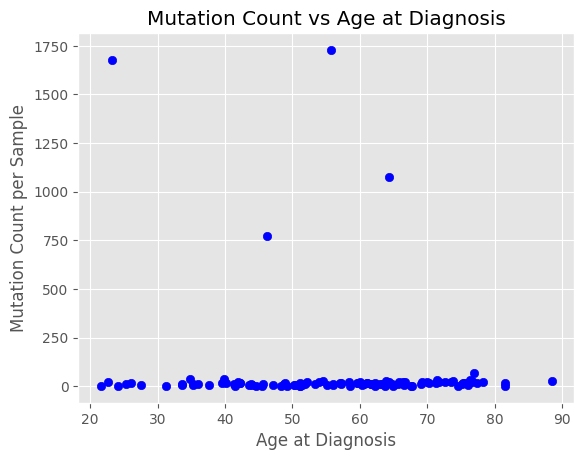

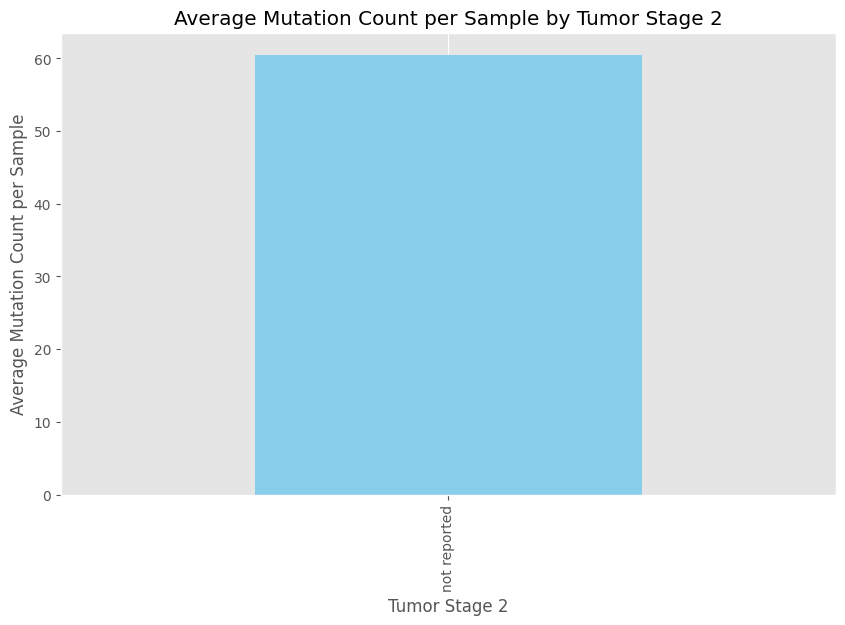

In [360]:
somatic_EDA(somatic_files[2], EDA_clinical_files[2])

## SKCM

Mutation Range: 207254
Mutation Average: 48357.14


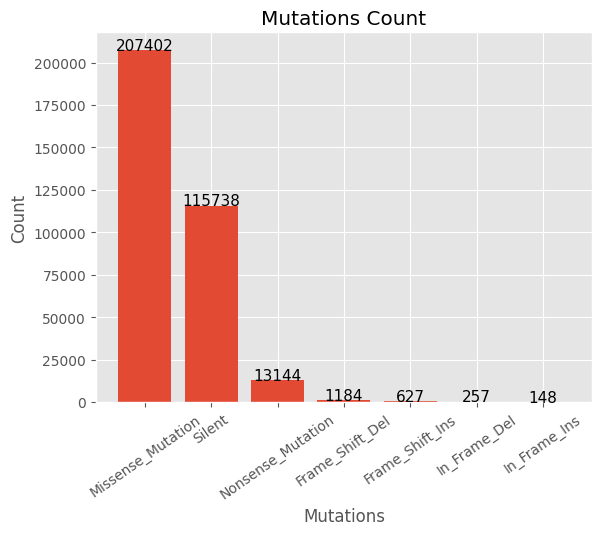

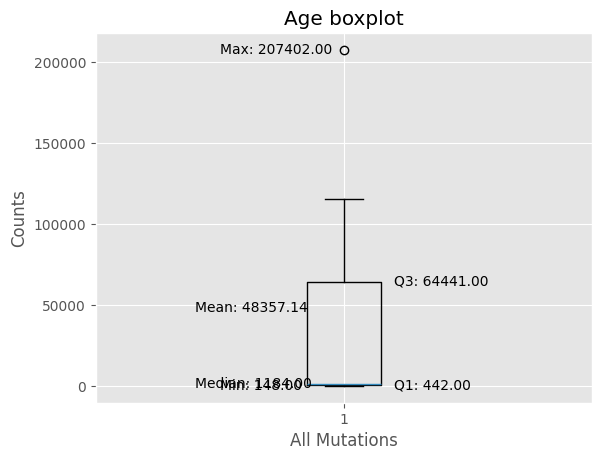

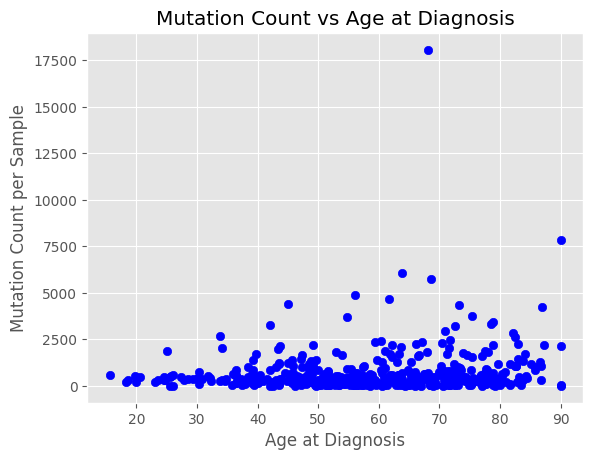

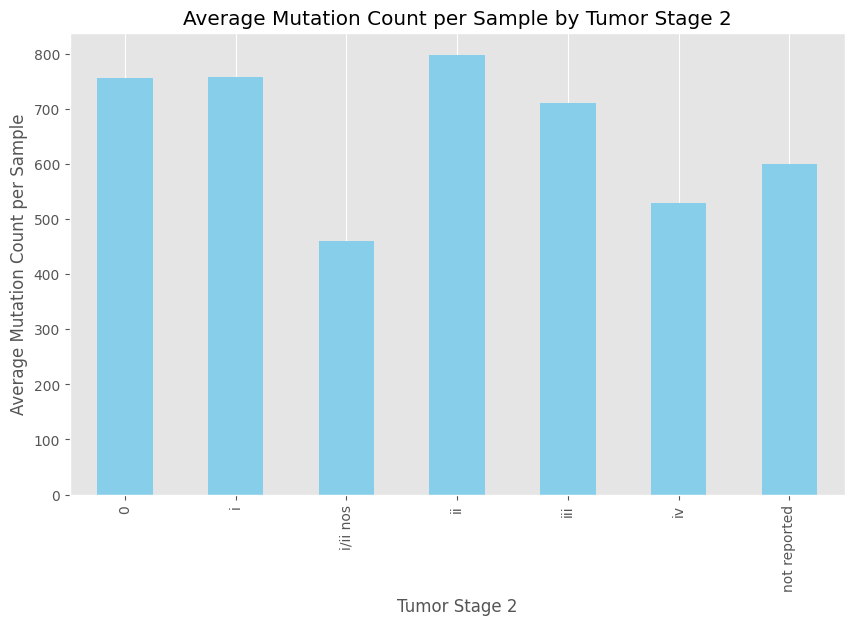

In [361]:
somatic_EDA(somatic_files[3], EDA_clinical_files[3])

# Discovering Cancer Driver Genes

## Bonferroni-corrected cutoff to reduce Type 1 Error

In [362]:
def cancer_driver_genes(gene_expected_file, cancer_file):
    with open(gene_expected_file, 'r') as file:
        data = file.read()
    gene_expected = pd.read_csv(io.StringIO(data), sep='\t')

    somatic = pd.read_csv(cancer_file, delimiter='\t', compression='gzip')

    silent_c = somatic['var_class'].str.count('Silent').sum()
    notSilent_c = somatic[somatic['var_class'] != 'Silent']['var_class'].count()
    file = cancer_file.split('/')[-1].split('.')[0]
    print(f'{file} Silent Mutations: {silent_c}')
    print(f'{file} Protein-Altering Mutations: {notSilent_c}')
    
    silent_c_group = somatic[somatic['var_class'] == 'Silent'].groupby('symbol').size().reset_index(name='obs_syn')
    nonsilent_c_group = somatic[somatic['var_class'] != 'Silent'].groupby('symbol').size().reset_index(name='obs_alt')
    mut_cnt = silent_c_group.merge(nonsilent_c_group, on='symbol', how='outer').fillna(0)
    mut_cnt['obs_fr'] = mut_cnt['obs_alt'] / (mut_cnt['obs_syn'] + mut_cnt['obs_alt'])
    
    top_10_pa_mut = mut_cnt.sort_values(by='obs_alt', ascending=False).head(10)
    print(f'\n{file} Top 10 most protein-altering mutations\n', top_10_pa_mut['symbol'])
    
    top_10_pa_mut_fra = mut_cnt.sort_values(by='obs_fr', ascending=False).head(10)
    print(f'\n{file} Top 10 genes with the highest fraction of protein-altering mutations\n', top_10_pa_mut_fra['symbol'])
    
    mut_cnt_more = mut_cnt.merge(gene_expected, on='symbol', how='inner')
    mut_cnt_more['exp_fr'] = mut_cnt_more['exp_alt'] / (mut_cnt_more['exp_syn'] + mut_cnt_more['exp_alt'])
    mut_cnt_more = mut_cnt_more[mut_cnt_more['obs_fr'] > mut_cnt_more['exp_fr']]
    
    num_comparisons = mut_cnt_more.shape[0] 
    alpha = 0.05  
    bonferroni_cutoff = alpha / num_comparisons
    
    print(f'Bonferroni-corrected p-value cutoff: {bonferroni_cutoff}')
    
    # Cancer Genes
    significant_genes = []
    
    for index, row in mut_cnt_more.iterrows():
        obs_syn, obs_alt = row['obs_syn'], row['obs_alt']
        exp_syn, exp_alt = row['exp_syn'], row['exp_alt']
        
        total_obs = obs_syn + obs_alt
        total_exp = exp_syn + exp_alt
        
        if total_obs != total_exp:
            scale_factor = total_obs / total_exp
            exp_syn *= scale_factor
            exp_alt *= scale_factor

        chi2, p_value = chisquare([obs_syn, obs_alt], f_exp=[exp_syn, exp_alt])
        
        if p_value < bonferroni_cutoff:
            significant_genes.append((row['symbol'], chi2, p_value))
    
    print(f"\nGenes with p-values below the Bonferroni-corrected cutoff of {bonferroni_cutoff}:")
    for gene in significant_genes:
        symbol, chi2, p_value = gene
        print(f"Gene: {symbol}, chi2: {round(chi2, 3)}, p-value: {round(p_value, 3)}")


## Loop Method

In [363]:
# with open (gene_expected[0], 'r') as file:
#     data = file.read()
# gene_expected = pd.read_csv(io.StringIO(data), sep = '\t')

# for file_path in somatic_files:
#     somatic = pd.read_csv(file_path, delimiter='\t', compression='gzip')

#     # mut_cnts = somatic['var_class'].value_counts()
#     # print(mut_cnts)
    
#     silent_c = somatic['var_class'].str.count('Silent').sum()
#     notSilent_c = somatic[somatic['var_class'] != 'Silent']['var_class'].count()
#     # notSilent_c = len(somatic[somatic['var_class'] != 'Silent'])
#     file = file_path.split('/')[-1].split('.')[0]
#     # print(f'{file} Silent Mutations: {silent_c}')
#     # print(f'{file} Protein-Altering Mutations: {notSilent_c}')
    
#     #New dataframe
#     silent_c_group = somatic[somatic['var_class'] == 'Silent'].groupby('symbol').size().reset_index(name = 'obs_syn')
#     nonsilent_c_group = somatic[somatic['var_class'] != 'Silent'].groupby('symbol').size().reset_index(name = 'obs_alt')
#     mut_cnt = silent_c_group.merge(nonsilent_c_group, on = 'symbol', how = 'outer').fillna(0)
#     mut_cnt['obs_fr'] = mut_cnt['obs_alt'] / (mut_cnt['obs_syn'] + mut_cnt['obs_alt'])

#     #obs_alt descending
#     top_10_pa_mut = mut_cnt.sort_values(by = 'obs_alt', ascending=False).head(10)
#     # print(f'\n{file} Top 10 most protein-altering mutations\n',top_10_pa_mut['symbol'])

#     # obs_fr descending 
#     top_10_pa_mut_fra = mut_cnt.sort_values(by = 'obs_fr', ascending=False).head(10)
#     print(f'\n{file} Top 10 genes with the highest fraction of protein-altering mutations\n',top_10_pa_mut_fra['symbol'])

#     #Discover Cancer Driver Genes
#     mut_cnt_more = mut_cnt.merge(gene_expected, on = 'symbol', how = 'inner')

#     mut_cnt_more['exp_fr'] = mut_cnt_more['exp_alt'] / (mut_cnt_more['exp_syn'] + mut_cnt_more['exp_alt'])

#     mut_cnt_more = mut_cnt_more[mut_cnt_more['obs_fr'] < mut_cnt_more['exp_fr']]

#     significant_genes = 0
#     for index, row in mut_cnt_more.iterrows():
#         obs_syn, obs_alt = row['obs_syn'], row['obs_alt']
#         exp_syn, exp_alt = row['exp_syn'], row['exp_alt']
        
#         total_obs = obs_syn + obs_alt
#         total_exp = exp_syn + exp_alt
#         if total_obs != total_exp:
#             scale_factor = total_obs / total_exp
#             exp_syn *= scale_factor
#             exp_alt *= scale_factor
        
#         chi2, p_value = chisquare([obs_syn, obs_alt], f_exp=[exp_syn, exp_alt])
#         alpha_bonf = 0.05 / len(mut_cnt_more)
#         if p_value < alpha_bonf:
#             significant_genes += 1
#         # print(f'Gene: {row["symbol"]}, chi2: {round(chi2, 3)}, p-value: {round(p_value, 3)}')
#     # print(f'Significant genes after Bonferri correction: {significant_genes}')

In [364]:
cancer_driver_genes(gene_expected[0], somatic_files[0])

ACC Silent Mutations: 2079
ACC Protein-Altering Mutations: 6577

ACC Top 10 most protein-altering mutations
 3060      MUC16
5241        TTN
1170     CTNNB1
5131       TP53
4300       RYR2
4759      SPTA1
780     CCDC168
3287        NRK
1044    CNTNAP5
3757      PKHD1
Name: symbol, dtype: object

ACC Top 10 genes with the highest fraction of protein-altering mutations
 0         A1BG
3362    OR10A4
3442    OR52E4
3441    OR52E2
3440    OR52D1
3439    OR51T1
3438    OR51I2
3437    OR51G1
3436    OR51F2
3435    OR51E1
Name: symbol, dtype: object
Bonferroni-corrected p-value cutoff: 1.2946659761781462e-05

Genes with p-values below the Bonferroni-corrected cutoff of 1.2946659761781462e-05:


In [365]:
cancer_driver_genes(gene_expected[0], somatic_files[1])

BRCA Silent Mutations: 22391
BRCA Protein-Altering Mutations: 73840

BRCA Top 10 most protein-altering mutations
 10788    PIK3CA
15029      TP53
15448       TTN
8934      MUC16
2471       CDH1
8242     MAP3K1
5430      GATA3
7508      KMT2C
12530      RYR2
6311      HMCN1
Name: symbol, dtype: object

BRCA Top 10 genes with the highest fraction of protein-altering mutations
 0            A1BG
8712         MPND
8700         MPC1
8701         MPC2
8705    MPHOSPH10
8707     MPHOSPH8
8710          MPL
8711       MPLKIP
8715         MPP3
8741       MRGPRE
Name: symbol, dtype: object
Bonferroni-corrected p-value cutoff: 5.615453728661276e-06

Genes with p-values below the Bonferroni-corrected cutoff of 5.615453728661276e-06:
Gene: CDH1, chi2: 36.284, p-value: 0.0
Gene: GATA3, chi2: 30.952, p-value: 0.0
Gene: MAP3K1, chi2: 27.65, p-value: 0.0
Gene: PIK3CA, chi2: 79.008, p-value: 0.0
Gene: TP53, chi2: 95.214, p-value: 0.0


In [366]:
cancer_driver_genes(gene_expected[0], somatic_files[2])

LAML Silent Mutations: 1976
LAML Protein-Altering Mutations: 6566

LAML Top 10 most protein-altering mutations
 5237       TTN
3007     MUC16
1383    DNMT3A
1746      FLT3
4243     RUNX1
3244      NPM1
2500       KIT
5114      TP53
2203      IDH2
5453       WT1
Name: symbol, dtype: object

LAML Top 10 genes with the highest fraction of protein-altering mutations
 0           A2M
3573      PCSK2
3569       PCM1
3567      PCID2
3565      PCF11
3561    PCDHGB5
3560    PCDHGB2
3559    PCDHGB1
3558    PCDHGA9
3557    PCDHGA8
Name: symbol, dtype: object
Bonferroni-corrected p-value cutoff: 1.268713524486171e-05

Genes with p-values below the Bonferroni-corrected cutoff of 1.268713524486171e-05:


In [367]:
cancer_driver_genes(gene_expected[0], somatic_files[3])

SKCM Silent Mutations: 115738
SKCM Protein-Altering Mutations: 222762

SKCM Top 10 most protein-altering mutations
 16425       TTN
9509      MUC16
4143      DNAH5
11133      PCLO
8486      LRP1B
346      ADGRV1
664        ANK3
3482      CSMD1
4145      DNAH7
5430        FLG
Name: symbol, dtype: object

SKCM Top 10 genes with the highest fraction of protein-altering mutations
 0            A1BG
10114      NPIPA2
10102        NPC2
2142       CAPZA1
2145        CAPZB
10079    NOTCH2NL
10056        NOL7
10052        NOL3
10051       NOL12
10036        NNAT
Name: symbol, dtype: object
Bonferroni-corrected p-value cutoff: 1.148369315571888e-05

Genes with p-values below the Bonferroni-corrected cutoff of 1.148369315571888e-05:
Gene: BRAF, chi2: 61.372, p-value: 0.0
Gene: NRAS, chi2: 33.058, p-value: 0.0
